In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2024-05-12 11:49:10.876107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 11:49:10.876264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 11:49:11.013138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df_temp = pd.read_csv("/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv")
df_temp.head()

,Unnamed: 0,Date,Sales
0,0,2021-10-01,29.109547
1,1,2021-10-02,30.720435
2,2,2021-10-03,30.305173
3,3,2021-10-04,27.390893
4,4,2021-10-05,22.841123


In [5]:
df = pd.read_csv("/kaggle/input/simulated-sales-data-with-timeseries-features/sales.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"])
df = df.drop(columns=["Unnamed: 0"])

df.head()

,Sales
Date,
2021-10-01,29.109547
2021-10-02,30.720435
2021-10-03,30.305173
2021-10-04,27.390893
2021-10-05,22.841123


In [8]:
df.tail()

,Sales
Date,
2022-09-26,43.698457
2022-09-27,38.827336
2022-09-28,38.761570
2022-09-29,41.144471
2022-09-30,45.529812


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-10-01 to 2022-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


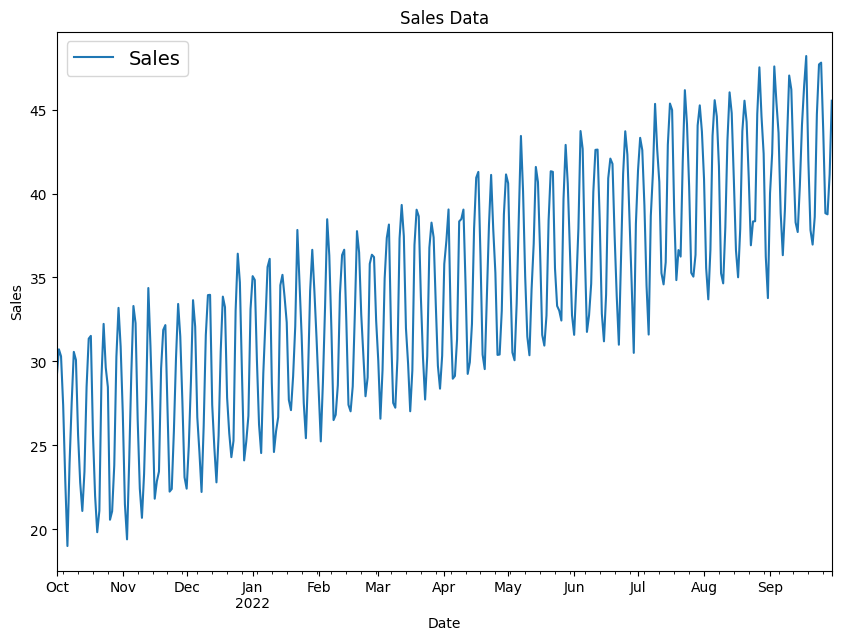

In [10]:
df.plot(figsize=(10,7))
plt.ylabel("Sales")
plt.title("Sales Data")
plt.legend(fontsize=14)

In [11]:
len(df)

365

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [22]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [23]:

# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = windowed_array[:, :-horizon], windowed_array[:, -horizon:]

  return windows, labels

In [25]:
X_train, y_train = make_windows(train_data, window_size=WINDOW_SIZE, horizon=HORIZON)
len(X_train), len(y_train)

(285, 285)

In [44]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {X_train[i]} -> Label: {y_train[i]}")

Window: [[0.34626976]
 [0.40145887]
 [0.38723196]
 [0.28738862]
 [0.1315133 ]
 [0.        ]
 [0.16794786]] -> Label: [[0.29263877]]
Window: [[0.40145887]
 [0.38723196]
 [0.28738862]
 [0.1315133 ]
 [0.        ]
 [0.16794786]
 [0.29263877]] -> Label: [[0.3962042]]
Window: [[0.38723196]
 [0.28738862]
 [0.1315133 ]
 [0.        ]
 [0.16794786]
 [0.29263877]
 [0.3962042 ]] -> Label: [[0.3797585]]


In [27]:
X_test, y_test = make_windows(test_data, window_size=WINDOW_SIZE, horizon=HORIZON)
len(X_test), len(y_test)

(66, 66)

In [29]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, activation='relu',return_sequences=True),
    tf.keras.layers.LSTM(128,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [30]:
model_lstm.compile( 
        loss=tf.keras.losses.mse,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mse"]
)

In [36]:
model_lstm.fit(X_train,y_train,epochs=100,
               batch_size=128,
            validation_data=(X_test, y_test))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0018 - mse:

In [38]:
model_lstm.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mse: 0.0018 


[0.0018874165834859014, 0.0018874165834859014]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


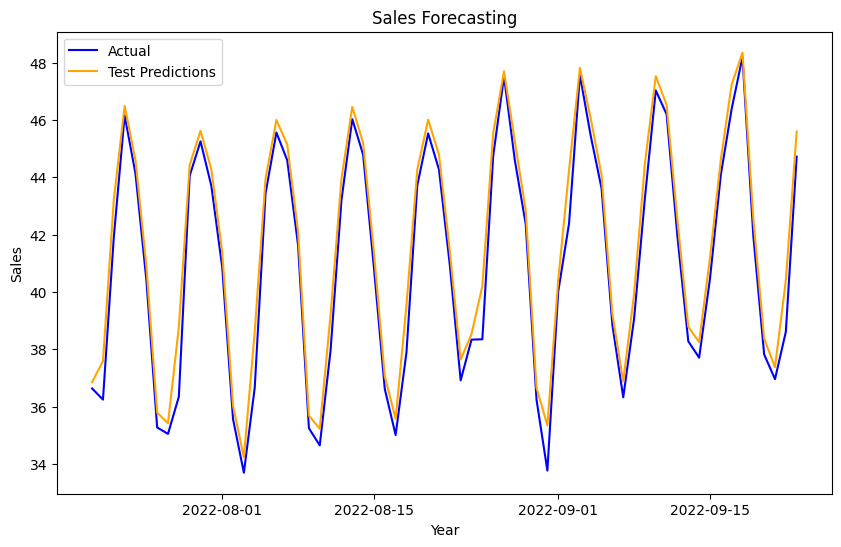

In [43]:
# Make predictions
train_predictions = model_lstm.predict(X_train)
test_predictions = model_lstm.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))


# Plot training predictions
#plt.plot(df.index[WINDOW_SIZE:WINDOW_SIZE+len(train_predictions)], train_predictions, label='Train Predictions',color='green')

# Plot testing predictionsWIND
test_pred_index = range(WINDOW_SIZE+len(train_predictions), WINDOW_SIZE+len(train_predictions)+len(test_predictions))


# Plot actual data
plt.plot(df.index[test_pred_index], df.loc[df.index[test_pred_index],'Sales'], label='Actual', color='blue')
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions',color='orange')

plt.title('Sales Forecasting')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.show()